### Exercise 1: 
##### Implement from scratch the k-NN algorithm in python programming language. Present your method and how you worked, conclude by discussing the disadvantages of the k-NN algorithm, if any.

The $k$-Nearest Neighbors algorithm ($k$-NN) is a **non-parametric** and **lazy learning**  method used for classification and regression. In the context of classification, its purpose is to use a dataset, in which the data points (training set) are separated into several classes, to predict the classification of new sample points (testing set).<br/>
It is considered "non-parametric", because it does not make any assumptions on the underlying data distribution (i.e. the model structure is determined by the data), and "lazy learning", because it does not use the training data points to do any *generalization* (i.e. there is no explicit training phase). <br/>
The algorithm relies on the assumption that "things that look alike must be alike". The rationale behind such a method is that the features that are used to describe the data points are relevant to their labelings in a way that makes close-by points likely to have the same label. So k-NN is based on **feature similarity** (sometimes called distance, proximity, or closeness): How closely out-of-sample features resemble our training set determines how we classify a given data point. <br/>
The input of the algorithm is the training data points, which are represented as vectors in a multidimensional feature space, each with a class label. The output is a class membership for a given (non-training/non-labeled) sample point. A point is classified by a plurality vote of its labeled neighbors, with the point being assigned to the class most common among its $k$ nearest neighbors (where $k$ is a positive integer, typically small). If $k = 1$, then the object is simply assigned to the class of that single nearest neighbor. <br/>
The following is an example of the $k$-NN algorithm where we have two classes of (training) data - Green and Brown - and we classify a new Black data point according to its $k=5$ nearest neighbors: </br>

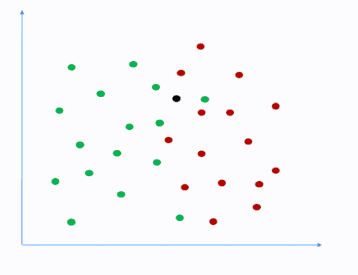 </br>

Finding the $k$ nearest neighbors of a testing point is done by calculating the distance between itself and each of the training points. This can be done by using various **distance metrics**, depending on the nature of the data and the intended applications of the algorithm. Some common distance functions for two (real-valued) vectors $a$ and $b$ are:
* *Euclidean Distance*: <br/>
  $$d(a,b)=\sqrt{\sum_{i=1}^n (b_i - a_i)^2}$$
* *Manhattan Distance*: <br/>
  $$d(a,b)=\sum_{i=1}^n \left|b_i - a_i\right|$$
* *Chebyshev Distance*: <br/>
  $$d(a,b)=\max_{i} (\left|b_i - a_i\right|)$$

**Disadvantages of $k$-NN**
* We need to determing the value of parameter $k$ (=number of nearest neighbors) beforehand and the best choice depends upon the data. A small value of $k$ means that the noise will have a higher influence on the result. A large value, on the other hand, makes it computationally expensive and kinda defeats the basic philosophy behind $k$-NN (which is that points that lie near each other might be in the same class), hence making the boundaries between classes less distinct
* The computational cost is quite high because we have to compute the distance of each testing point to **every** training point, and also store all (or almost all) of the training data, hence making it impossible to use in large datasets
* It needs homogeneous features: If we decide to build $k$-NN using a common distance, like Euclidean or Manhattan distances, it is completely necessary that features have the same scale, since absolute differences in features weight the same. That is, a given distance in feature 1 must mean the same for feature 2. For example, suppose we want to classify people according to features like *height* (in meters) and *weight* (in pounds). We can see that there is low variability between the heights (e.g. 1.5m to 1.85m) and high variability between the weights (e.g. 90lbs to 250lbs) of the people. So if we don't take into consideration the scale of the features, the distances between the points will be **dominated** by differences in the weight. To overcome this problem, we have to do some [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) on our data, using methods like [normalization](https://en.wikipedia.org/wiki/Normalization_(statistics)) or [standardization](https://en.wikipedia.org/wiki/Standard_score)
* The basic "majority voting" classification (assigning to a data point the most frequent class of its $k$ closest neighbors) isn't ideal when the **class distribution** is skewed. That is, examples of a more frequent class tend to dominate the prediction of the new example, because they tend to be common among the $k$ nearest neighbors due to their large number. One way to overcome this problem is to **weight** the classification, taking into account the distance from the test point to each of its k nearest neighbors
* Curse of Dimensionality (see Exercise 2)

**Pseudocode**

*Algorithm*: $k$NN_Classification($S_{train},S_{test},k$) <br/> 
Input: A set $S_{train}$ of labeled data points and a set $S_{test}$ of unlabeled data points, represented as feature vectors in the plane <br/>
Output: A label (class assignment) for each of the unlabeled data points

1. &emsp;**for** $test$ in $S_{test}$ **do**
2. &emsp;&emsp;Let $distances$ be a list that holds the distances between $test$ and every training point, along with the training points themselves
3. &emsp;&emsp;**for** $train$ in $S_{train}$ **do**
4. &emsp;&emsp;&emsp;Compute the distance $d(test,train)$, depending on the metric used, and append it to $distances$ along with $train$
5. &emsp;&emsp;Sort $distances$ in ascending order and select the $k$ nearest neighbors
6. &emsp;&emsp;Assign to $test$ the most frequent label among its $k$ nearest neighbors

**Note!** We will implement the $k$-NN algorithm (for this exercise) from scratch using only the standard library (i.e. **no** Pandas, NumPy, SciPy, Scikit-Learn etc.)

In [1]:
# For Exerices 1 and 5
from random import seed, randrange
from csv import reader
from math import sqrt
# For Exercises 2 and 3
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

In [2]:
# Calculate the Euclidean distance between two vectors (data points) - the range is adapted for the Iris Dataset in Question 5
def euclidean_distance(vector1, vector2):
    distance = 0.0
    for i in range(1,len(vector1)-1):                         # for each column (feature) except the first (id) and the last (label)
        distance += (vector1[i] - vector2[i])**2
    return sqrt(distance)

# Calculate the Manhattan distance between two vectors (data points)
def manhattan_distance(vector1, vector2):
    distance = 0.0
    for i in range(1,len(vector1)-1):
        distance += abs((vector1[i] - vector2[i]))
    return distance

# Calculate the Chebysev distance between two vectors (data points)
def chebyshev_distance(vector1, vector2):
    distance = []
    for i in range(1,len(vector1)-1):
        distance.append(abs((vector1[i] - vector2[i])))
    return max(distance)

# Find the k closest neighbors of a test point and return them along with their distances from that point
def k_nearest_neighbors(train_set, test_point, k, metric):
    distances = list()
    for train_point in train_set:                             # compute the distance between test_point and every data point in the training set
        if metric=='manhattan':
            dist = manhattan_distance(test_point, train_point)
        elif metric=='chebyshev':
            dist = chebyshev_distance(test_point, train_point)
        else:
            dist = euclidean_distance(test_point, train_point)
        distances.append((train_point, dist))                 # save the distance along with the train point itself (as a tuple)
    distances.sort(key=lambda tup: tup[1])                    # sort the list in ascending order of the distance
    neighbors = [distances[i][0] for i in range(k)]           # get only the k closest neighbors from the sorted list and return them
    return neighbors

# Classify an unlabeled test point (vector) according to its k nearest neighbors from a labeled set of training points
def knn_classification(train_set, test_point, k, metric):
    neighbors = k_nearest_neighbors(train_set, test_point, k, metric) # find the k nearest neighbors of that test_point
    labels = [neighbor[-1] for neighbor in neighbors]                 # get the labels of the k closest neighbors
    prediction = max(set(labels), key=labels.count)                   # get the most frequent label
    return prediction

# See the following Exercises for a use of the above functions

### Exercise 2: 
##### Using the code provided at the class (or implementing your own) explain what the curse of dimensionality is and how it is related to the k-NN algorithm.

The **Curse of Dimensionality** refers to various phenomena that arise when analyzing and organizing data in high-dimensional spaces that do not occur in low-dimensional settings such as the three-dimensional physical space of everyday experience. The common theme of these problems is that when the dimensionality increases, the volume of the space increases so fast that the available data become sparse. </br>
In the context of supervised machine learning, and the $k$-NN classification specifically, this is important, because predictions for new samples are based on learning from similar training features. When calculating the Euclidean distance between two points, each new dimension adds a non-negative term to the sum, so the distance increases with the number of dimensions for distinct vectors and, therefore, the "neighbors" become less similar. In other words, the philosophy of $k$-NN that *similar objects  lie in close proximity* ceases to exist.

The figures below show what happens when we have a **fixed size** of training examples and an increasing number of dimensions. Suppose we have 50 randomly generated data points, with values for each dimension between 0 and 100: <br/>
In 1 dimension, with 5 intervals, there will be, *on average*, $\frac{50}{5} = 10$ points per cell <br/>
In 2 dimensions, with 5 intervals on the $1^{st}$ dimension and 5 intervals on the $2^{nd}$ dimension, there will be, *on average*, $\frac{50}{5\cdot5} = 2$ points per cell <br/>
In 3 dimensions, with 5 intervals on each dimension, there will be, *on average*, $\frac{50}{5\cdot5\cdot5}=0.4$ points per cell <br/>

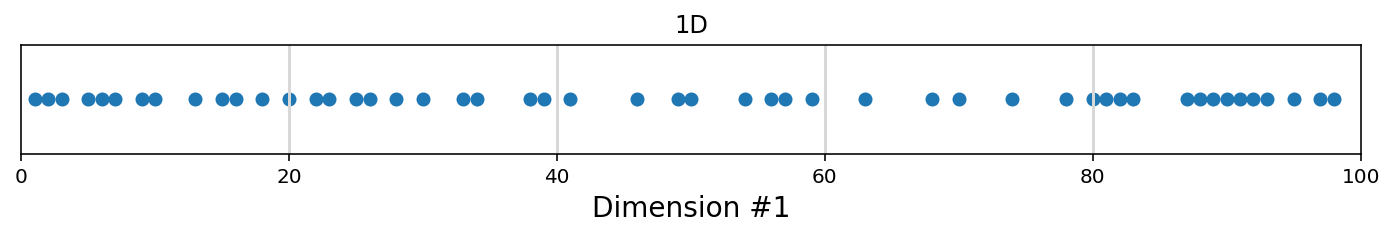

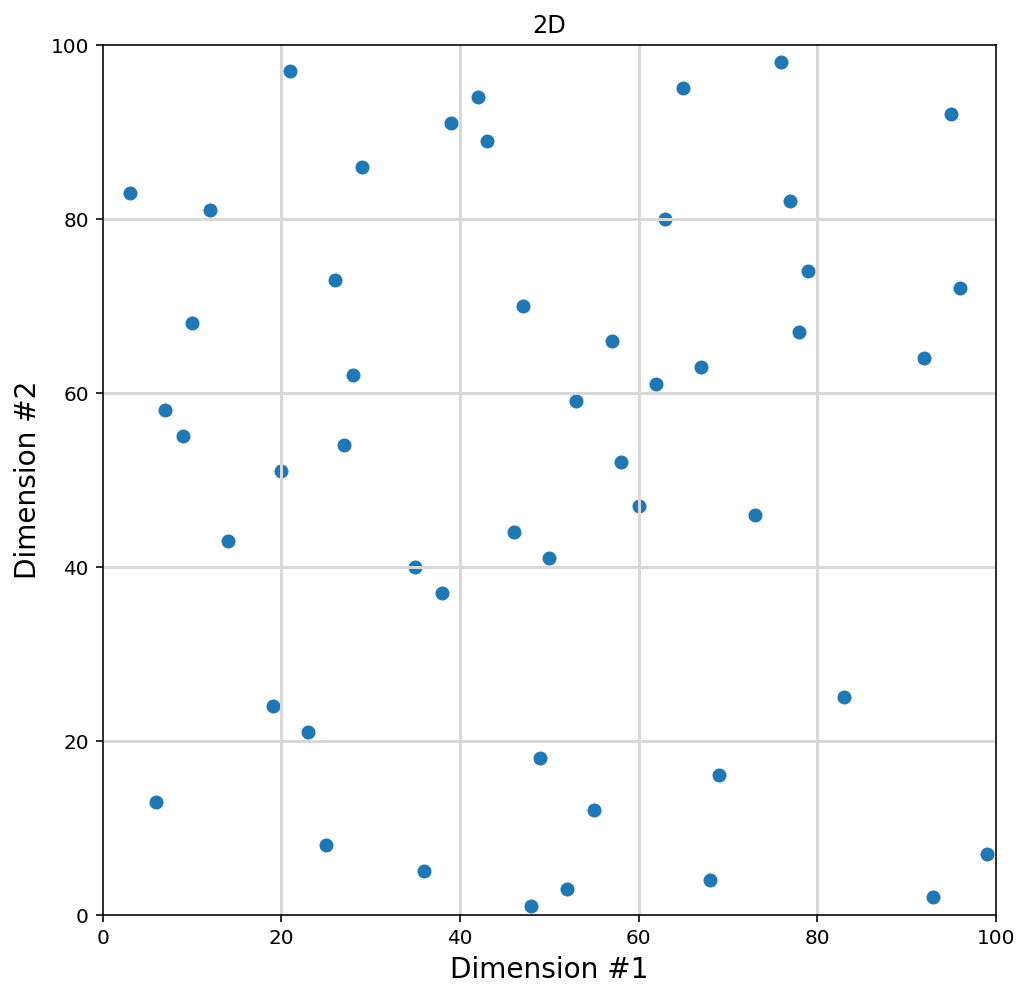

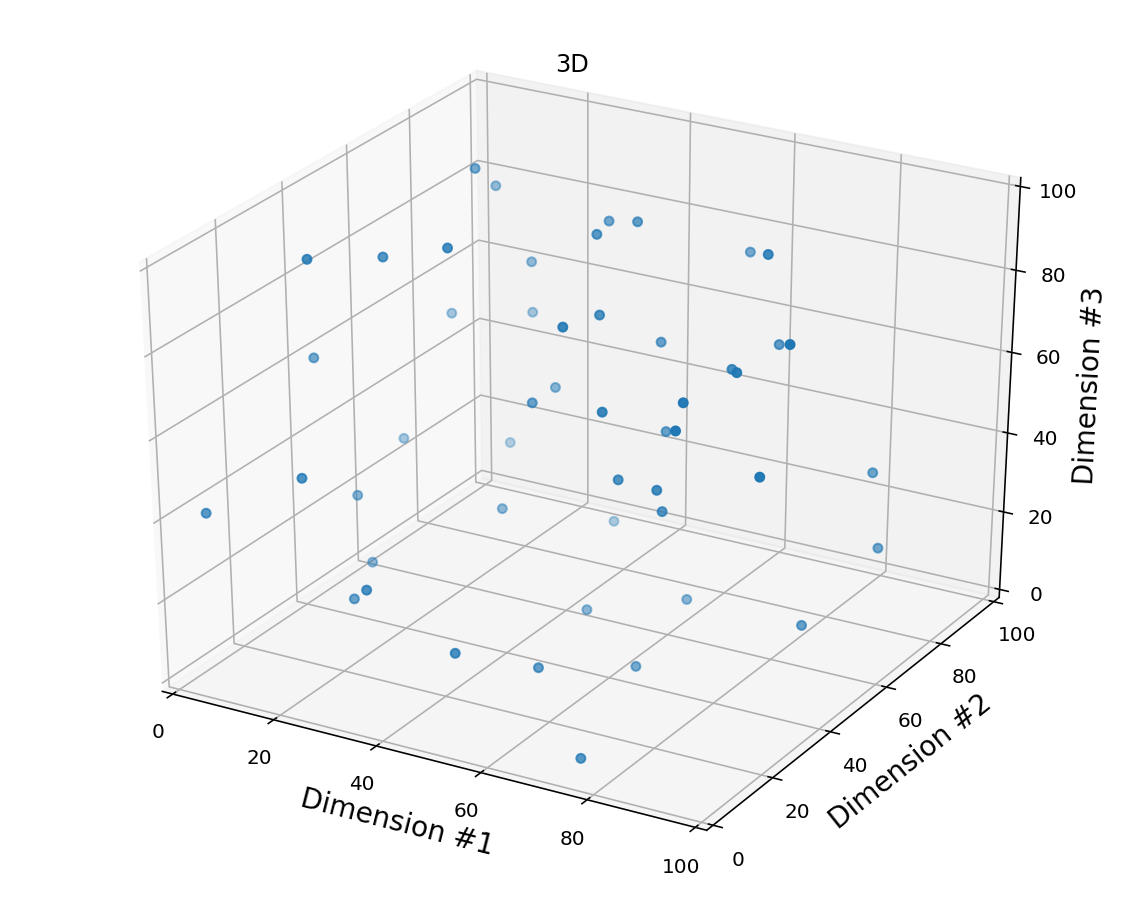

In [3]:
# 1 DIMENSION
fig = plt.figure()
ax  = plt.axes()
fig.set_size_inches(12, 1)
x = random.sample(range(0, 100), 50)
y = [0 for xval in x]
plt.scatter(x, y)
for grid_pt in [20, 40, 60, 80]:              # Grid lines
    plt.axvline(x=grid_pt, color='#D8D8D8')
ax.set_xlim((0,100))
ax.set_xlabel("Dimension #1", fontsize=14)
ax.set_ylabel("")
plt.yticks([], [])
plt.title("1D")
plt.show()

# 2 DIMENSIONS
fig = plt.figure()
ax  = plt.axes()
fig.set_size_inches(8, 8)
x = random.sample(range(0, 100), 50)
y = random.sample(range(0, 100), 50)
plt.scatter(x, y)
for grid_pt in [20, 40, 60, 80]:              # Grid lines
    plt.axvline(x=grid_pt, color='#D8D8D8')
    plt.axhline(y=grid_pt, color='#D8D8D8')
ax.set_xlim((0,100))
ax.set_ylim((0,100))
ax.set_xlabel("Dimension #1", fontsize=14)
ax.set_ylabel("Dimension #2", fontsize=14)
plt.title("2D")
plt.show()

# 3 DIMENSIONS
fig = plt.figure()
ax  = fig.add_subplot(1,1,1,projection='3d')
fig.set_size_inches(10, 8)
x = random.sample(range(0, 100), 50)
y = random.sample(range(0, 100), 50)
z = random.sample(range(0, 100), 50)
ax.scatter(x, y, z)
for grid_pt in [20, 40, 60, 80]:              # Grid lines
    plt.axvline(x=grid_pt, color='#D8D8D8')
    plt.axhline(y=grid_pt, color='#D8D8D8')
ax.set_xlim(0,100)
ax.set_ylim(0,100)
ax.set_zlim(0,100)
ax.set_xlabel("Dimension #1", fontsize=14)
ax.set_ylabel("Dimension #2", fontsize=14)
ax.set_zlabel("Dimension #3", fontsize=14)
plt.title("3D")
plt.show()

As we can see, adding more dimensions to our fixed number of data, makes the feature space increasingly sparse (less dense) and the distance between the points increases rapidly. So as the distance between the points grows that much, the whole idea of having *nearby neighbors* doesn't apply anymore, and the distance functions lose their usefulness. In general, when the number of dimensions is very large, all points become dissimilar and the $k$ "closest" points can't really tell us much about the possible label/class of a new point, because they're not similar to that point at all. <br/> <br/>
As we just showed, even 3 dimensions become *intense* for our 50 (which is a very small number) data points. Let's see what happens with a higher number of data points, in even higher dimensions. We will randomly generate **pairs of points** in the d-dimensional “unit cube” in a variety of dimensions, and calculate the distances between them. We will see that the **mean** distance between the pairs grows as the number of dimensions increases.

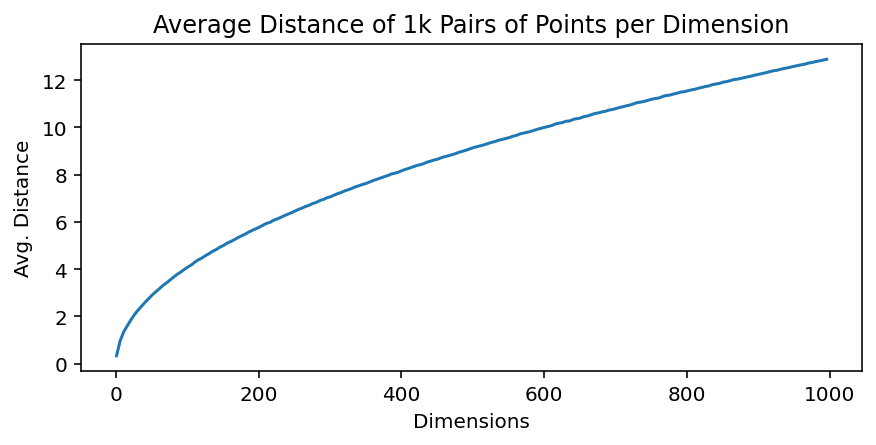

In [4]:
def distance(vector1,vector2):
    distance = 0.0
    for i in range(len(vector1)):
        distance += (vector1[i] - vector2[i])**2
    return sqrt(distance)

def mean(x):
    return sum(x) / len(x)

# Generate a random point with values between zero and one from each of its dimensions
def random_point_gen(dimension):
    return [random.random() for _ in range(dimension)]

# Generate pairs of points in a given "dimension" and calculate their the distances (Euclidean distance)
def random_distances_comparison(dimension,num_of_pairs):
    return [distance(random_point_gen(dimension),random_point_gen(dimension)) for _ in range(num_of_pairs)]

def plot(dimensions,avg_distances):
    plt.figure().set_size_inches(7, 3)
    plt.plot(dimensions,avg_distances)
    plt.title("Average Distance of 1k Pairs of Points per Dimension")
    plt.xlabel('Dimensions')
    plt.ylabel('Avg. Distance')
    plt.show()

def main():
    dimensions = range(1, 1000, 5)                          # Dimensions in range of 1 to 1000 with interval of 5

    avg_distances = []
    for dims in dimensions:
        distances = random_distances_comparison(dims, 1000) # generate 1k pairs of points in dims dimension and calculate their distances
        avg_distances.append(mean(distances))               # mean distance for these pairs
    plot(dimensions,avg_distances)

if __name__ == "__main__":
    main()

If we kept adding dimensions, the amount of training data would need to grow exponentially as fast to maintain the same coverage of the feature space. To combat the Curse of Dimensionality, $k$-NN is usually performed in practice after a dimensionality reduction preprocessing step.

### Exercise 3:
##### 1. Suppose there is a set of points on a two-dimensional plane from two different classes. Points in class Red are (0, 1), (2, 3), (4, 4) and points in class Blue are (2, 0), (5, 2), (6, 3). Draw the k-nearest-neighbor decision boundary for k = 1 as we discussed in the lecture. Experiment yourself with two or more diferrent distance metrics. Present your results.

When we train a classifier on a dataset, we are using a specific algorithm to define a set of hyperplanes that separates the data points into specific classes. Where the algorithm switches from one class to the other we call it a *decision boundary*. On one side of a decision boundary, a datapoint is more likely to be called as one class — on the other side of the boundary, it’s more likely to be called as another. On that particular region of a decision boundary the output label of a classifier is ambiguous. Decision boundaries are not confined to just the data points we provided — they span through the entire feature space we trained on.

In the context of $k$-NN classification (in 2 dimensions), decision boundaries in 1-NN are concatenated segments of the [Voronoi Tessallation](https://en.wikipedia.org/wiki/Voronoi_diagram). The Voronoi tessellation of a set of objects decomposes space into Voronoi cells, where each object's cell consists of all points that are closer to the object than to other objects. In our case, the objects are the training points. The Voronoi tessellation then partitions the plane into convex polygons, each containing its corresponding training point (and no other), where a convex polygon is a convex region in 2-dimensional space bounded by lines. <br/>
For general $k$ in $k$-NN, consider the region in the space for which the set of $k$ nearest neighbors is the same. This again is a convex polygon and the space is partitioned into convex polygons, within each of which the set of $k$ nearest neighbors is invariant.

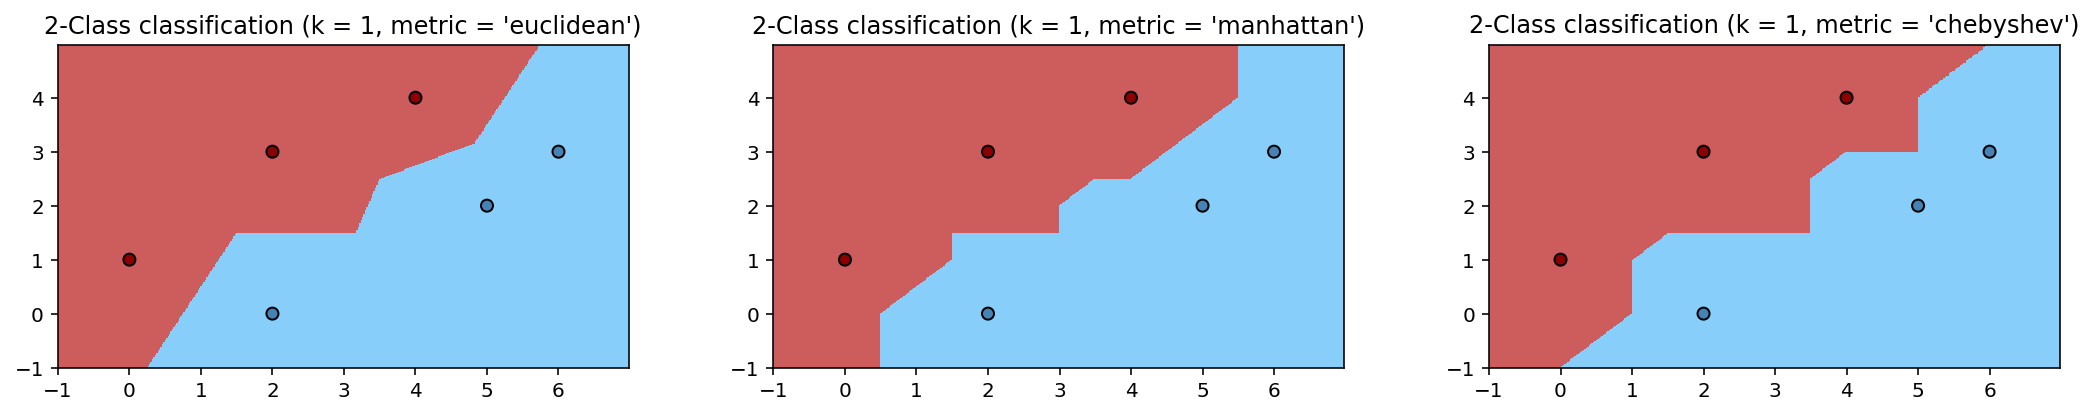

In [5]:
def knn_decision_boundary(train_set,k):
    train_set_features = np.array([ item[1:3] for item in train_set])
    train_set_labels = np.array([ item[3] for item in train_set])

    # Plot the decision boundary. For that, we will asign a color to each point in the mesh [f1_min, f1_max]x[f2_min, f2_max].
    h = .02  # step size in the mesh
    f1_min, f1_max = train_set_features[:, 0].min() - 1, train_set_features[:, 0].max() + 1
    f2_min, f2_max = train_set_features[:, 1].min() - 1, train_set_features[:, 1].max() + 1
    f1_values, f2_values = np.meshgrid(np.arange(f1_min, f1_max, h),np.arange(f2_min, f2_max, h))
    test_set = np.c_[f1_values.ravel(), f2_values.ravel()].tolist()
    for test_point in test_set:
        test_point.insert(0,"ID")
        test_point.append("Label")

    ax = plt.figure(figsize=(15,3))
    for i,metric in enumerate(['euclidean','manhattan','chebyshev']):
        #predict the label of each point in the mesh
        predictions = [knn_classification(train_set, test_point, k, metric) for test_point in test_set]

        # Create color maps
        cmap_light = ListedColormap(['indianred', 'lightskyblue'])
        cmap_bold = ListedColormap(['darkred', 'steelblue'])
        # Plot all the testing points (light color)
        predictions = np.array(predictions).reshape(f1_values.shape)
        ax.add_subplot(1,3,i+1)
        plt.pcolormesh(f1_values, f2_values, predictions, cmap=cmap_light)
        # Plot all the training points (dark color)
        plt.scatter(train_set_features[:, 0], train_set_features[:, 1], c=train_set_labels, cmap=cmap_bold,
                    edgecolor='k')
        plt.xlim(f1_values.min(), f1_values.max())
        plt.ylim(f2_values.min(), f2_values.max())
        plt.title("%d-Class classification (k = %d, metric = '%s')" % (len(set(train_set_labels)), k, metric))

    plt.tight_layout()
    plt.show()

def main():
    # Classes -> "Red" = 0, "Blue" = 1
    train_set = [ ["Point1", 0, 1, 0], ["Point2", 2, 3,0], ["Point3", 4, 4, 0], ["Point4", 2, 0, 1], ["Point5", 5, 2, 1], ["Point6", 6, 3, 1] ]
    knn_decision_boundary(train_set,1)

if __name__ == "__main__":
    main()

##### 2. If the y-coordinate of each point was multiplied by 5, what would happen to the k=1 boundary? Draw a new picture. Explain whether this effect might cause problems in practice.

As we mentioned in Exercise 1, one of the weaknesses of $k$-NN (and other machine learning algorithms that use distance functions), is that our data attributes should have the same scale. If one of the features has a broad range of values, the distance will be governed by this particular feature. In fact, this is what happened below when we multiplied the y-coordinate of each point by 5. The range of values for that feature increased, while the range for the other feature did not. We can, clearly, see that it is the differences in the y-coordinate that define the decision boundary. It is as if the x-coordinate doesn't play that much of a role in the classification. <br/>
Such data that contain attributes with a mixture of scales can definitely cause problems in practice. Therefore, the range of all features should always be normalized so that each feature contributes approximately proportionately to the final distance.

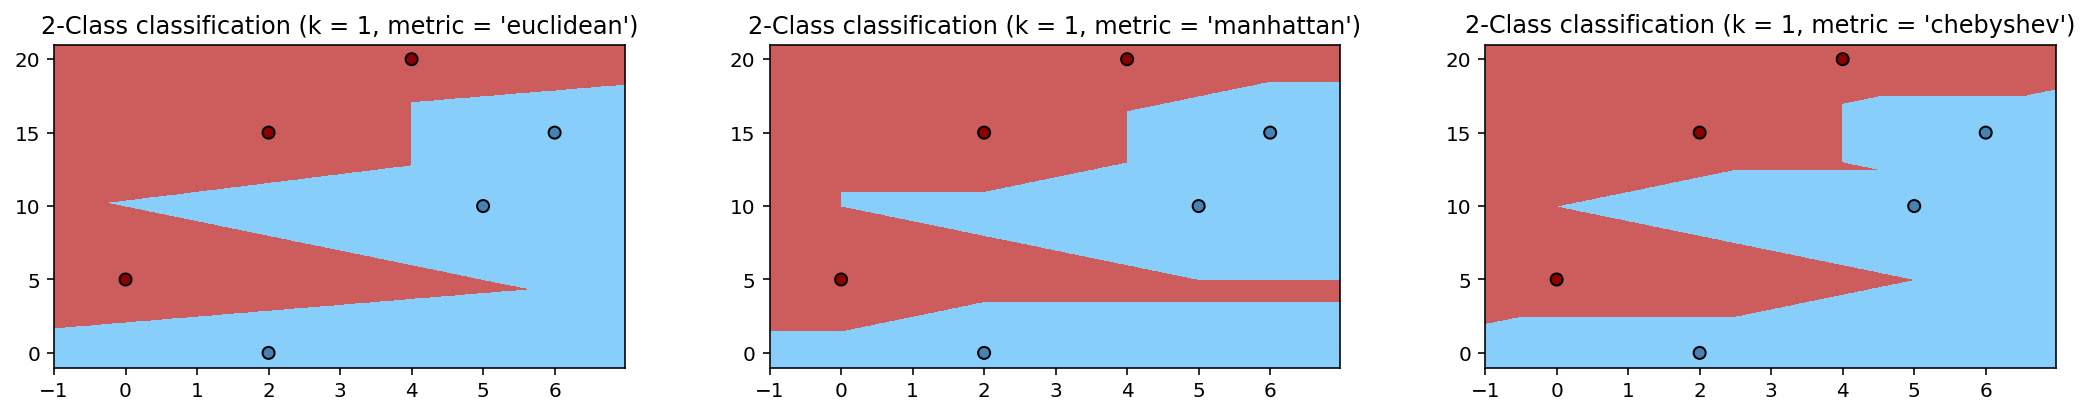

In [6]:
def main():
    train_set = [['Point1', 0, 5, 0], ['Point2', 2, 15, 0], ['Point3', 4, 20, 0], ['Point4', 2, 0, 1], ['Point5', 5, 10, 1], ['Point6', 6, 15, 1]]
    knn_decision_boundary(train_set,1)

if __name__ == "__main__":
    main()

##### 3. Can you draw the decision boundary for k=3?

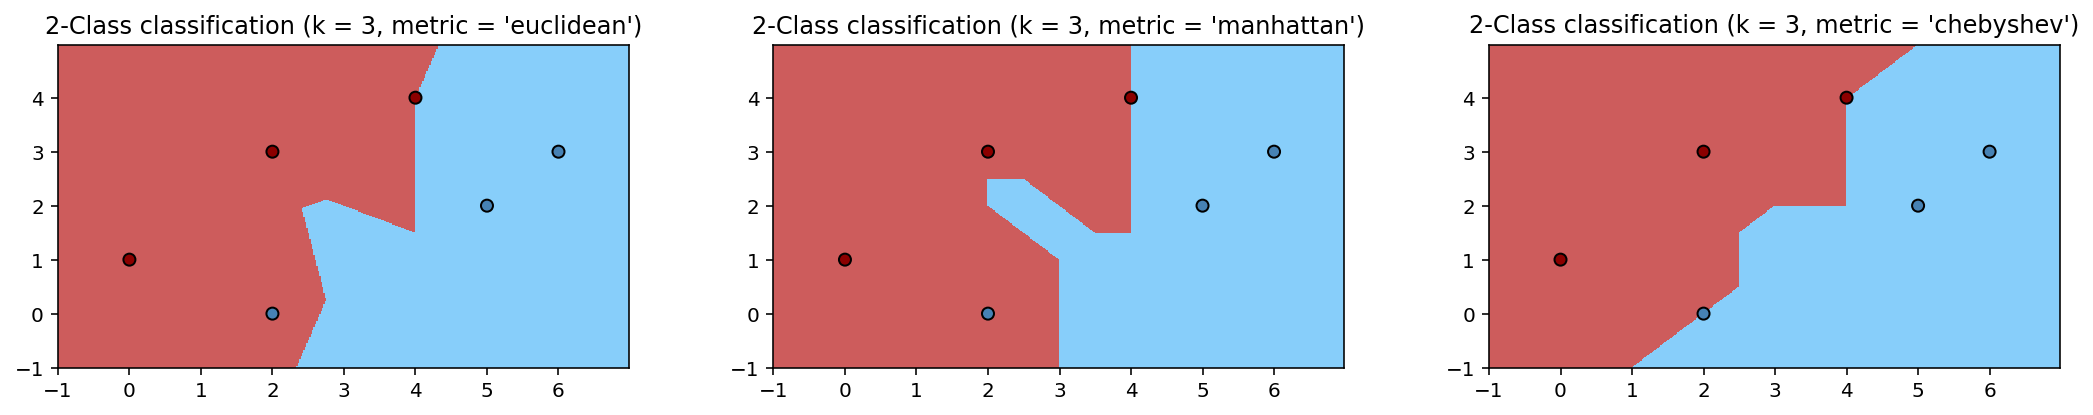

In [7]:
def main():
    train_set = [ ["Point1", 0, 1, 0], ["Point2", 2, 3,0], ["Point3", 4, 4, 0], ["Point4", 2, 0, 1], ["Point5", 5, 2, 1], ["Point6", 6, 3, 1] ]
    knn_decision_boundary(train_set,3)

if __name__ == "__main__":
    main()

##### 4. Suppose now we have a test point at (1, 2). How would it be classied under 3-NN? Given that you can modify the 3-NN decision boundary by adding points to the training set in the diagram, what is the minimum number of points that you need to add to change the classification at (1, 2)? Provide also the coordinates for these new points and justify your answer.

As we can see in the decision boundary plots, test point (1,2) would be classified as 'Red' (0) in all three cases. And we did verify that in the code below. This is because its 3 nearest neighbors are (0,1,'Red'),(2,3,'Red'),(2,0,'Blue'), so given that two them are red and one is blue, our test point is classified as 'Red'.

We know that the decision boundary has a high variability since it depends upon the training samples. Changing the composition of our training set would change the decision boundary. So by adding points to our training set we can change the classification of point (1,2) from 'Red' to 'Blue', and for that to happen we will need a majority of 'Blue' labels between the 3 nearest neighbors of the point. The distance of our testing point to its two red nearest neighbors is smaller than the distance to its one blue nearest neighbor, so adding only a single blue neighbor close to our point would only kick out the current nearby blue point from the set of its 3 nearest neighbors, and we'd still be left with two red ones and a blue (just closer than the previous) one. <br/>
Thus, to change the classification of point (1,2) we need to add at least two blue points, to our training set, that are closer to (1,2) than its current red nearest neighbors are. For example, points (1,1.5,'Blue') and (1,1.4,'Blue') would work, as we can see below.

 Classes -> Red = 0, Blue = 1 
With the initial training set:
For k=3 and metric=euclidean, point [1, 2] is labeled as 0
For k=3 and metric=manhattan, point [1, 2] is labeled as 0
For k=3 and metric=chebyshev, point [1, 2] is labeled as 0

After the addition of [['NewPoint', 1, 1.5, 1], ['NewPoint', 1, 1.4, 1]] to our training set:


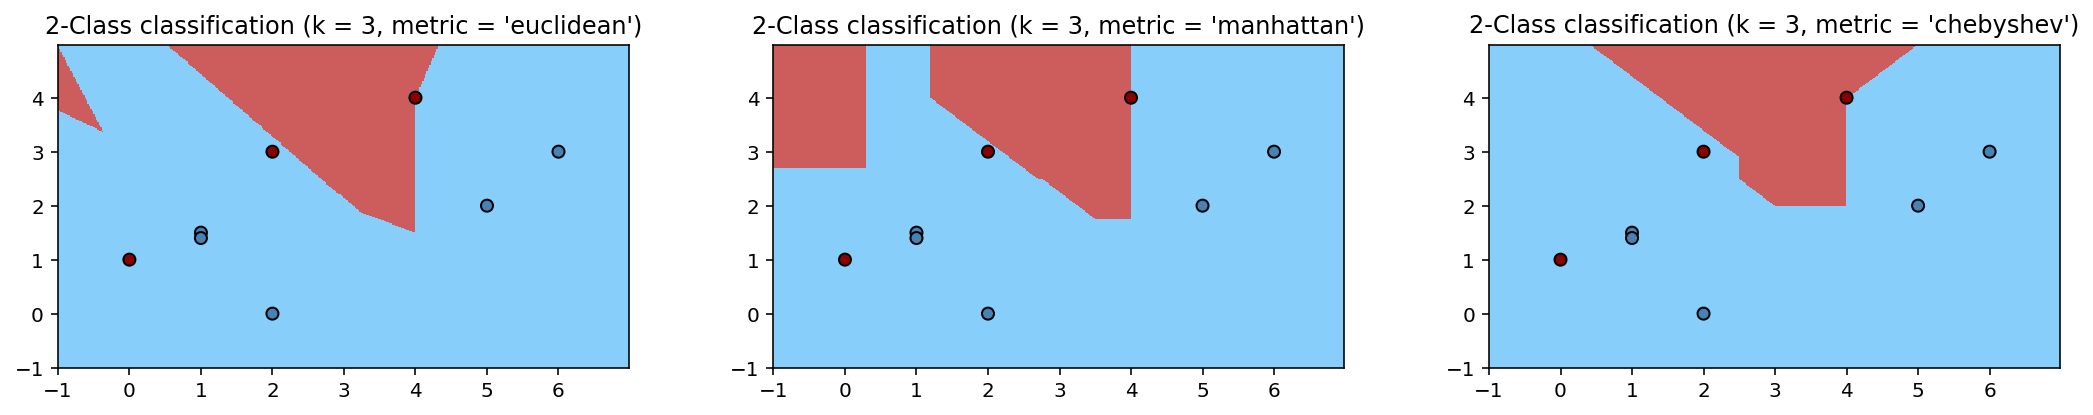

For k=3 and metric=euclidean, point [1, 2] is labeled as 1
For k=3 and metric=manhattan, point [1, 2] is labeled as 1
For k=3 and metric=chebyshev, point [1, 2] is labeled as 1


In [8]:
def main():
    print(" Classes -> Red = 0, Blue = 1 ")
    print("With the initial training set:")
    train_set = [ ["Point1", 0, 1, 0], ["Point2", 2, 3,0], ["Point3", 4, 4, 0], ["Point4", 2, 0, 1], ["Point5", 5, 2, 1], ["Point6", 6, 3, 1] ]
    test_point = ["newpoint",1,2,"label"]
    for metric in ["euclidean","manhattan","chebyshev"]:
        pred = knn_classification(train_set, test_point, 3, metric)
        print("For k=3 and metric=%s, point %s is labeled as %d" % (metric,test_point[1:3],pred))

    new_point1 = ["NewPoint",1,1.5,1]
    new_point2 = ["NewPoint",1,1.4,1]
    train_set.append(new_point1)
    train_set.append(new_point2)
    print("\nAfter the addition of %s to our training set:" % ([new_point1,new_point2]))
    knn_decision_boundary(train_set,3)
    for metric in ["euclidean","manhattan","chebyshev"]:
        pred = knn_classification(train_set, test_point, 3, metric)
        print("For k=3 and metric=%s, point %s is labeled as %d" % (metric,test_point[1:3],pred))
if __name__ == "__main__":
    main()

### Exercise 4:
##### How long does it take for k-NN to classify one point? Or in other words what is the testing complexity for one instance? Assume your data has dimensionality d, you have n training examples and use Euclidean distance. Assume also that you use a quick select implementation which gives you the k smallest elements of a list of length m in O(m).

Assuming that we use the pseudocode we introduced in Exercise 1, except that we find the $k$ smallest items of an unsorted list in linear time instead of sorting the list, we need:

* $O(d)$ time to compute the distance between two vectors with the Euclidean distance, where $d$ is the dimensionality of our data (i.e. the number of features per data point)
* $O(m)$ time to find the $k$ smallest elements in a list (i.e. the $k$ nearest neighbors in our $distances$ list) of length $m$

Thus, we need $O(nd)$ time to compute the distances between one testing point and all of our $n$ training examples. We also need $O(m)$ time to find the $k$ smallest items in our $distances$ list after we've calculated all the distances (in fact, we'd need $O(km)$ time to find all $k$ nearest neighbors, but the exercise states that we can, supposedly, find all of them in $O(m)$ time, since $k$ is a constant). All other operations take constant time, so the total running time for the classification of a **single** point is $O(nd+m)$

### Exercise 5:
##### To see an application of the k-NN algorithm in a real world classification problem consider the data found at https://www.kaggle.com/uciml/iris. Download from there the Iris.csv file. Ignore the id column and consider the columns: SepalLengthCm, SepalWidthCm, PetalLengthCm, PetalWidthCm as point coordinates in a four dimensional space. Consider the column Species as the class/label column. The file contains 150 rows. Run the algorithm on the first 100 rows and make predictions for the rest 50. How are your predictions compared to the actual? Explain your methodology.

The Iris dataset is structured in such a way that the first 50 rows are labeled 'Iris-setosa', the second 50 'Iris-versicolor' and the last 50 'Iris-virginica'. So if we want to train on the first 100 and predict the labels of the last 50, we need to do some shuffling (cause otherwise we would wrongly label all the virginica species as one of the other two). We will randomly split the Iris dataset into two parts. We will train the algorithm on the first part, make predictions on the second part and evaluate the predictions against the expected results. This is, usually, done when we need to know how well our algorithms perform on unseen data, by making predictions on data to which we already know the answers (but haven't trained on them, cause otherwise we'd be overfitting on the training data)

**Note!** This is not the best method to predict how well our algorithm will behave on new (unseen) data. For a better estimation of the accuracy of our predictive model we should use resampling methods from statistics, like the k-fold Cross Validation Split etc.

In [9]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    dataset.pop(0)                                               #remove the first row (description)
    return dataset

# Convert a "feature" column from string to float
def feature_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

# Map the class labels to integers e.g. Iris-setosa=0, Iris-versicolor=1 and so on
def class_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
        print('%s = %d' % (value, i))
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

# Split a dataset into a train and test set
def train_test_split(dataset, split=0.67):                       #Split (randomly) 0.67% of the dataset into train and 33% into test points
    train_set = list()
    train_size = split * len(dataset)
    test_set = list(dataset)
    while len(train_set) < train_size:
        index = randrange(len(test_set))
        train_set.append(test_set.pop(index))
    return train_set, test_set

# Calculate accuracy percentage
def accuracy_metric(correct, predicted):
    correct_num = 0
    for i in range(len(correct)):
        if correct[i] == predicted[i]:
            correct_num += 1
    return correct_num / float(len(correct)) * 100.0

def main():
    # Make predictions with KNN on Iris Dataset
    dataset = load_csv('Iris.csv')                               # dataset will be a list of lists (list of vectors represented as lists)
    for i in range(len(dataset[0])-1):                           # feature values are stored as strings, so we convert them to floats
        feature_column_to_float(dataset, i)
    class_column_to_int(dataset, len(dataset[0])-1)              # convert "class" column to integers
    k = 5                                                        # number of nearest neighbors

    for metric in ["euclidean","manhattan","chebyshev"]:
        print("\nUse of %s distance:" % metric)
        # Predict for single point using the whole dataset
        test_point = [0.0, 5.1, 2.5, 3.0, 1.1, 0.0]                  # [id,...features...,label], only features matter
        label = knn_classification(dataset, test_point, k, metric)
        print('Single prediction with the whole dataset as training set: Point = %s -> Prediction = %s' % (test_point[1:len(test_point)-1], label))

        # Estimate the predicted accuracy of the algorithm
        seed(1)                                                      # to ensure the same split each time the code is executed
        train_set, test_set = train_test_split(dataset)              # split the dataset into train_set and test_set
        predicted = [knn_classification(train_set, test_point, k, metric) for test_point in test_set]
        correct = [test_point[-1] for test_point in test_set]
        accuracy = accuracy_metric(correct,predicted)                # compare the predictions to the correct labels to get the accuracy
        print("The predicted accuracy of the algorithm with k = %d and this specific split of the dataset is %.5f%%" % (k,accuracy))

if __name__ == "__main__":
    main()

Iris-virginica = 0
Iris-setosa = 1
Iris-versicolor = 2

Use of euclidean distance:
Single prediction with the whole dataset as training set: Point = [5.1, 2.5, 3.0, 1.1] -> Prediction = 2
The predicted accuracy of the algorithm with k = 5 and this specific split of the dataset is 95.91837%

Use of manhattan distance:
Single prediction with the whole dataset as training set: Point = [5.1, 2.5, 3.0, 1.1] -> Prediction = 2
The predicted accuracy of the algorithm with k = 5 and this specific split of the dataset is 93.87755%

Use of chebyshev distance:
Single prediction with the whole dataset as training set: Point = [5.1, 2.5, 3.0, 1.1] -> Prediction = 2
The predicted accuracy of the algorithm with k = 5 and this specific split of the dataset is 95.91837%
